## Data loading

We'll begin by doing PCA on our train + test datasets to see how separable our classes are.

In [5]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import zipfile
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

zf_train = zipfile.ZipFile('../../data/train.csv.zip')
train = pd.read_csv(zf_train.open('train.csv'), index_col=0)

zf_test = zipfile.ZipFile('../../data/test.csv.zip')
test = pd.read_csv(zf_test.open('test.csv'), index_col=0)


## Dimensions of train set
ntrain,dtrain = train.shape

## Dimensions of test set
ntest, dtest = test.shape

/home/carolyn/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Columns with zero variance

Columns with zero variance are labeled as 1; columns with variation are labeled as 0. 

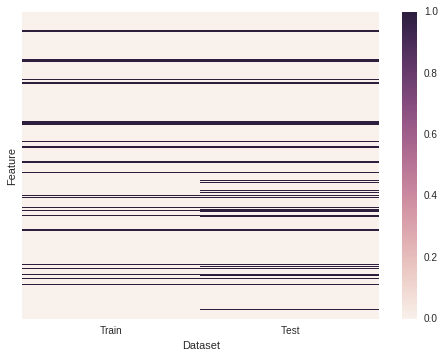

In [6]:
a = np.all(train == train.iloc[0,], axis = 0)[0:dtrain-1]
b = np.all(test == test.iloc[0,], axis = 0)
identicals = np.column_stack((a,b))

ax = sns.heatmap(identicals, xticklabels=['Train', 'Test'], yticklabels=False)
ax.set(xlabel='Dataset', ylabel='Feature')
plt.show()

In [7]:
train = pd.concat([train.iloc[:,~a], train.iloc[:,len(train.columns)-1]], axis=1)
test = test.iloc[:,~a]

This is good news -- columns with 0 variance in the test dataset are a subset of those in the train dataset. If this was **not** true, our training set would not be sufficient for classification of our test set. 

## Principal components analysis

In [8]:
def pca_plot(X, targets, title):
    target_names = np.unique(targets)
    pca = PCA(n_components = 2)
    X_r = pca.fit(X).transform(X)
    X_scaled = preprocessing.scale(X_r)
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))

    plt.figure()
    for c, i, target_name in zip("rb", [0, 1], target_names):
        plt.scatter(X_scaled[np.where(targets == i),0], X_scaled[np.where(targets == i),1], c=c, label=target_name)
    plt.legend()
    plt.title(title)

def kernel_pca(X, targets, title, kernel, **kwargs):
    kpca = KernelPCA(kernel=kernel, fit_inverse_transform=True, **kwargs)
    X_kpca = kpca.fit_transform(X)
    X_back = kpca.inverse_transform(X_kpca)
    pca_plot(X_back, targets, title)

/home/carolyn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


explained variance ratio (first two components): [ 0.08049659  0.05159295]
explained variance ratio (first two components): [ 0.0867327  0.053668 ]


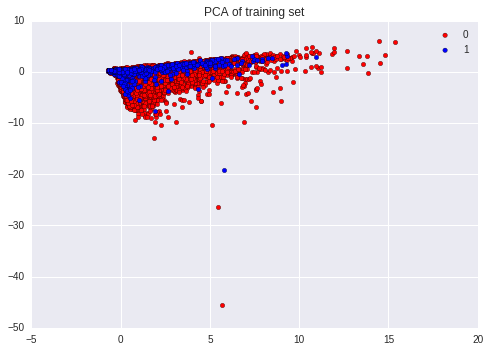

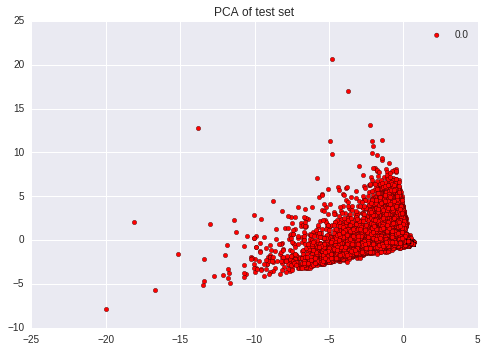

In [9]:
X = train.drop(['TARGET'], axis=1)

## Add a column that tells us how many 0's we have
X['n0'] = (X == 0).sum(axis=1)

Xtest = test
Xtest['n0'] = (Xtest == 0).sum(axis=1)

## Standardize sets together
def standardize_sets(X, Xtest):
    Xtotal = X.append(Xtest)
    Xtotal_scaled = preprocessing.scale(Xtotal)
    X_scaled,Xtest_scaled = np.split(Xtotal_scaled, [ntrain])
    return [X_scaled, Xtest_scaled]

X_scaled,Xtest_scaled = standardize_sets(X, Xtest)

targets = np.array(train.TARGET)
pca_plot(X_scaled, targets, title='PCA of training set')

eggs = np.zeros((ntest,1))
pca_plot(Xtest_scaled, eggs, title='PCA of test set')

We'll add the first two principal components as features. 

## Kernel PCA

This is very, very slow on the full dataset, and should not be run.

In [10]:
#kernel_pca(X, targets, title='Kernel PCA of training set', kernel='poly', degree=3)

## Feature selection

We'll select features based on univariate Chi-squared and F-tests.

In [11]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

## Top 75th percentile
p = 75
y = targets

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X.columns) if f_classif_selected[i]]
selected = chi2_selected & f_classif_selected
features = [ f for f,s in zip(X.columns, selected) if s]

## Number of features selected
print(len(features))

X_selected = X[features]
Xtest_selected = Xtest[features]

X_selected,Xtest_selected = standardize_sets(X_selected, Xtest_selected)

233


## Create validation set

Since we have no test set to evaluate our performance on, we must create a validation set from a subset of our training set. This set will not be used for training and is NOT to be confused with the validation set used for cross-validation. 

In [12]:
from sklearn import cross_validation

sss = cross_validation.StratifiedShuffleSplit(targets, 1, test_size=0.4, random_state=4224)
(train_index,valid_index) = list(sss)[0]

X_train = X_selected[train_index,]
X_valid = X_selected[valid_index,]
y_train = targets[train_index]
y_valid = targets[valid_index]

print(X_train.shape)
print(X_valid.shape)

(45612, 233)
(30408, 233)


## t-SNE visualization

This is slow; even when running on a small subset of features (see below). As a result, do not run this unless you anticipate having >2 hours of processing time. 

In [13]:
from sklearn import manifold
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize

In [14]:
features = ['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult3', 
'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult1', 
'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_ult1', 'ind_var8_0', 
'ind_var30_0', 'ind_var30', 'num_op_var41_hace2', 'num_op_var41_ult3', 
'num_var37_med_ult2', 'saldo_var5', 'saldo_var8', 'saldo_var26', 'saldo_var30', 
'saldo_var37', 'saldo_var42', 'imp_var43_emit_ult1', 'imp_trans_var37_ult1', 
'num_var22_hace2', 'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3',
'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_meses_var39_vig_ult3',
'num_op_var39_comer_ult1', 'num_op_var41_efect_ult3', 'num_op_var39_efect_ult1',
'num_var43_recib_ult1', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1',
'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 
'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_medio_var8_hace2',
'saldo_medio_var8_ult1', 'saldo_medio_var8_ult3', 'saldo_medio_var12_ult3',
'saldo_medio_var13_corto_hace2', 'var38']


def subset_features(mat, features, columns):
    df = pd.DataFrame(mat, columns=columns)
    subset = df[features]
    return(subset)

X.columns
X.shape

(76020, 336)

In [15]:



X_train_subset = subset_features(X_train, features, X.columns)
X_valid_subset = subset_features(X_valid, features, X.columns)


#tsne = manifold.TSNE(n_components=2, init='pca', random_state=1, n_iter=1000, verbose=20)

#X_tsne = tsne.fit_transform(X_valid_subset)

ValueError: Shape of passed values is (233, 45612), indices imply (336, 45612)

In [16]:
plt.figure()
plt.scatter(X_tsne[np.where(y_valid == 0), 0],
                   X_tsne[np.where(y_valid == 0), 1],
                   marker='x', color='g',
                   linewidth='1', alpha=0.8, label='Happy')
plt.scatter(X_tsne[np.where(y_valid == 1), 0],
                   X_tsne[np.where(y_valid == 1), 1],
                   marker='v', color='r',
                   linewidth='1', alpha=0.8, label='Unhappy')

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE on 10% train samples')
plt.legend(loc='best')
plt.savefig('1.png')
plt.show()  

NameError: name 'X_tsne' is not defined

## Utilities

In [17]:
from sklearn import metrics

## Computes AUC based on validation set
def compute_auc(preds):
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, preds, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_feature_importance(importances):
    feature_importance = 100.0 * (importances / importances.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[-10:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X[features].columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

## Logistic regression

Logistic regression with `scikit-learn` is way too slow; this should not be run. 

In [18]:
from sklearn.linear_model import LogisticRegression

def logreg_cv(X_train, y_train, c, fold):
    logreg = LogisticRegression(penalty='l2', dual=False, max_iter=100, C=c)
    cv_scores = cross_validation.cross_val_score(logreg, X_train, y_train, cv=fold)
    return np.mean(cv_scores)


In [19]:
## Too slow

#lambdas = np.power(float(2), range(-10,11))

#result = [logreg_cv(X_train, y_train, c, 3) for c in lambdas]

As we can see, logistic regression with an L2-regularizer is way too slow on this dataset.

## XGBoost

The size of our dataset necessitates the use of models that are faster to train. XGBoost has a built-in logistic regression model that can be exploited for this purpose. 

### Logistic regression

In [20]:
import xgboost as xgb
import re
import StringIO

def parse_string(cv_string):
    a = cv_string.split("\t")[1]
    return re.search('(?<=:)[0-9.]+', a).group(0)

ImportError: No module named xgboost

We use cross-validation to select the optimal value of lambda and the number of rounds. We can also select the optimal values of eta, max_depth, etc.

Since the evaluation function used in the Kaggle competition is the AUC, we use that here as well. 

For time purposes, I've set the maximum num_round to 20. This can and should be increased for better results though. 

**The code chunk below is also very slow (~ 30 minutes).** 

In [ ]:
lambdas = np.power(float(2), range(10,20))

## Runs with old parameter set. Needs updating. 
def xgb_cv_lambda(X_train, y_train, l, max_round=10):
    dtrain = xgb.DMatrix(X_train, y_train)
    
    param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic', 'lambda':l }
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    num_round = max_round
    
    ## verbose_eval=False isn't available in my version of xgboost (0.4.0)
    actualstderr = sys.stderr
    sys.stderr = StringIO.StringIO()
    results = xgb.cv( param, dtrain, num_round, 3, fpreproc = fpreproc)
    sys.stderr = actualstderr
    sys.stderr.flush()
    
    test_errors = [float(i) for i in [parse_string(c) for c in results]]
    return [np.max(test_errors), np.argmax(test_errors)]


cv_errors = [xgb_cv_lambda(X_train, y_train, l, 20) for l in lambdas]

#bst.save_model('0001.model')

#ypred = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
#sum(y_valid == ypred)/float(len(y_pred))

Having found our best parameter values, we can train with those to get the desired model. Here I've hardcoded parameters that seem to be quite good. 

In [ ]:
xgb_clf = xgb.XGBClassifier(missing=9999999999,max_depth = 5,n_estimators=1000,learning_rate=0.1, nthread=4,subsample=1.0,
                          colsample_bytree=0.5,min_child_weight = 3,reg_alpha=0.03,scale_pos_weight = ratio,seed=4224)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_train, y_train), (X_valid, y_valid)])

Our best AUC is:

In [ ]:
xgb_clf.best_score

Achieved on iteration:

In [ ]:
xgb_clf.best_iteration

In [ ]:
plot_feature_importance(xgb_clf.feature_importances_)

### Extreme value regression

In [ ]:
def extreme_objective(preds, dtrain):
    labels = dtrain.get_label()
    e = np.exp(preds)
    p = 1.0 / (1.0 - np.exp(-e))
    grad = labels*(1-p)*e + (1-labels)*e
    hess = labels*np.power(e,2)*(p-1)*p + (1-labels)*e
    return grad, hess

def train_and_predict_extreme(X_train, y_train, X_test, y_test, l, existing_prediction = False, preprocess = True, n=20):
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_valid, y_valid)
    
    param = {'bst:max_depth':3, 'bst:eta':1, 'silent':1, 'lambda':l }
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    
    def evalerror(preds, dtrain):
        labels = dtrain.get_label()
        # return a pair metric_name, result
        # since preds are margin(before logistic transformation, cutoff at 0)
        return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

    if preprocess == True:
        dtrain, dtest, param = fpreproc(dtrain, dtest, param)
        
    evallist  = [(dtest,'eval'), (dtrain,'train')]
    
    ## Boost from existing prediction
    if existing_prediction == True:
        actualstderr = sys.stderr
        sys.stderr = StringIO.StringIO()
        bst = xgb.train(param, dtrain, n, evallist, extreme_objective)
        sys.stderr = actualstderr
        sys.stderr.flush()
        
        tmp_train = bst.predict(dtrain, output_margin=True)
        tmp_test = bst.predict(dtest, output_margin=True)
        dtrain.set_base_margin(tmp_train)
        dtest.set_base_margin(tmp_test)
        bst = xgb.train(param, dtrain, n, evallist, extreme_objective)
    else:
        bst = xgb.train(param, dtrain, n, evallist, extreme_objective)
    return bst;

In [ ]:
train_and_predict_extreme(X_train, y_train, X_valid, y_valid, bestlambda, existing_prediction=True, preprocess=False, n=100)

As we can see, extreme value regression can sometimes perform a little better than logistic regression, but not by much. 

## Extra trees classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble
from sklearn import metrics

extc = ExtraTreesClassifier(n_estimators=200,max_features= 30,criterion= 'entropy',min_samples_split= 2,
                            max_depth= 30, min_samples_leaf= 2, n_jobs = -1)

extc.fit(X_train,y_train)

In [ ]:
extc_pred = extc.predict_proba(X_valid)
extc_pred = [x[1] for x in extc_pred]

compute_auc(extc_pred)

This works pretty well, with a reasonably good AUC of around 0.80.  

## Random forest

Imported from Henry's random forest notebook. Fixed to output probabilities, rather than class labels (since AUC operates on probabilities). 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 300, class_weight="auto", bootstrap=True, criterion='entropy', 
                               max_features=30, n_jobs = -1)
forest = forest.fit(X_train, y_train)

forest_train = forest.predict_proba(X_train)[:,1]
forest_pred = forest.predict_proba(X_valid)[:,1]

compute_auc(forest_pred)

## Sofia-ml

Sofia-ml uses stochastic gradient descent to optimize the SVM objective (regularized hinge loss). Pysofia doesn't seem to have a way to specify the regularization parameter...

In [ ]:
from pysofia import sgd_train, sgd_predict

class SofiaMLClassifier():
    def __init__(self, max_iter=10000, model='roc'):
        self.clf = None
        self.max_iter = max_iter
        self.model = model

    def fit(self, X, y, max_iter=None):
        max_iter = max_iter or self.max_iter
        query_id = np.ones(len(X))
        self.coef, _ = sgd_train(X, y, query_id, 1., model=self.model, max_iter=max_iter)
        self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))

    def predict(self, X):
        num2label = dict((i, label) for label, i in self.label2num.items())
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])

    def predict_proba(self, X):
        preds = sgd_predict(X, self.coef)
        preds = 1./(1.+np.exp(-preds))
        return np.vstack((1-preds, preds)).T

    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        if 'max_iter' in params:
            self.max_iter = params.pop('max_iter')
        self.params.update(params)
        return self

Sofia-ml doesn't output probabilities, so note that we do a logistic transform. 

In [ ]:
sofia = SofiaMLClassifier(model='roc')
sofia.fit(X_train,y_train, max_iter = 30000)

sofia_pred = sofia.predict_proba(X_valid)[:,1]

compute_auc(sofia_pred)

## Ensemble methods

We'll put the following methods in an ensemble:

* Gradient boosted trees (XGBoost)
* SVM (sofia-ml)
* Random forest
* Extra trees

### Classifiers

In [ ]:
from sklearn.cross_validation import StratifiedKFold

n_folds = 5

ratio = float(np.sum(y_train == 1)) / np.sum(y_train == 0)

clfs = [xgb.XGBClassifier(missing=9999999999,max_depth = 5,n_estimators=1000,learning_rate=0.1, nthread=4,subsample=1.0,
                          colsample_bytree=0.5,min_child_weight = 3,reg_alpha=0.03,scale_pos_weight = ratio,seed=4224),
        SofiaMLClassifier(model='roc'),
        ExtraTreesClassifier(n_estimators=200,max_features= 30,criterion= 'entropy',min_samples_split= 2,
                            max_depth= 30, min_samples_leaf= 2, n_jobs = -1),
        RandomForestClassifier(n_estimators = 300, class_weight="auto", bootstrap=False, criterion='entropy', 
                               max_features=30, n_jobs = -1)]

### Training multiple models

In [ ]:
skf = list(StratifiedKFold(y_train, n_folds))

blend_train = np.zeros((X_train.shape[0], len(clfs))) # Number of training data x Number of classifiers
blend_test = np.zeros((X_valid.shape[0], len(clfs))) # Number of testing data x Number of classifiers

for j, clf in enumerate(clfs):
        print 'Training classifier [%s]' % (j)
        blend_test_j = np.zeros((X_valid.shape[0], len(skf)))
        
        for i, (train_index, cv_index) in enumerate(skf):
            print 'Fold [%s]' % (i)
            
            # This is the training and validation set
            X_cv_train = X_train[train_index]
            y_cv_train = y_train[train_index]
            X_cv_test = X_train[cv_index]
            y_cv_test = y_train[cv_index]
            
            if j == 0:
                clf.fit(X_cv_train, y_cv_train, early_stopping_rounds=50, eval_set=[(X_cv_test, y_cv_test)], 
                        eval_metric='auc', verbose=False)
            else: 
                clf.fit(X_cv_train, y_cv_train)
            
            # This output will be the basis for our blended classifier to train against,
            # which is also the output of our classifiers
            blend_train[cv_index, j] = clf.predict_proba(X_cv_test)[:,1]
            blend_test_j[:, i] = clf.predict_proba(X_valid)[:,1]
        # Take the mean of the predictions of the cross validation set
        blend_test[:, j] = blend_test_j.mean(1)

The AUC for each of the models in our ensemble is:

In [ ]:
np.apply_along_axis(compute_auc, 0, blend_test)

### Visualizing correlations

It helps by first visualizing what the correlations are between different classifiers. This will give us an idea of whether it will be helpful to use both within the same ensemble (if they are well correlated, using them together won't improve our results by much). 

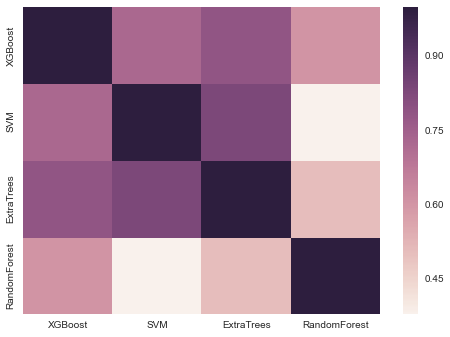

In [18]:
from scipy.stats import spearmanr

sp_test = spearmanr(blend_test)
sp_test_cor = sp_test.correlation

names = ["XGBoost", "SVM", "ExtraTrees", "RandomForest"]
cors = pd.DataFrame(sp_test_cor, index=names, columns=names)

sns.heatmap(cors)

### Combining models

There are several ways to combine the results of models.

#### Arithmetic mean of probabilities

In [19]:
pmean_preds = np.mean(blend_test, axis=1)

compute_auc(pmean_preds)

0.80303861415911804

Clearly, this isn't very good -- it's a downgrade from the XGBoost and ExtraTrees classifiers alone. 

#### Mean rank

In [20]:
from scipy.stats import rankdata

ranks = np.apply_along_axis(rankdata, 0, blend_test)
mean_ranks = np.apply_along_axis(np.mean, 1, ranks)

normalized_ranks = mean_ranks/max(mean_ranks)
compute_auc(normalized_ranks)

0.83311818325555165

This does a bit better but still isn't better than the XGBoost classifier alone. 

#### Stacking

Apparently, linear regression is supposed to be one of the best models for a stacking layer. 

https://www.kaggle.com/c/amazon-employee-access-challenge/forums/t/4928/combining-the-results-of-various-models

Indeed, for our data, it vastly outperforms a `LogisticRegression` blender (AUC 0.8069).

In [21]:
from sklearn.linear_model import LinearRegression

## Linear blending layer
bclf = LinearRegression()
bclf.fit(blend_train, y_train)
    
# Predict now
y_hat = bclf.predict(blend_test)

compute_auc(y_hat)

0.84186203156151151

This does even better than using mean ranks, but still doesn't beat the XGBoost classifier alone. We can alternatively try fitting pairs of classifiers only -- the best pair is:

In [22]:
bclf = LinearRegression()
bclf.fit(blend_train[:,[0,3]], y_train)
    
y_hat = bclf.predict(blend_test[:,[0,3]])

compute_auc(y_hat)

0.8458654055382574

Which performs very slightly (0.0003) better than the XGBoost classifier itself. 

### Calibration curves

As an aside, it helps to visualize what the confidence of each of our classifiers is -- how close to the "ideal" classifier they are. 

In [23]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def plot_calibration_curve(preds, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for prob_pos, nm in zip(preds, name):

        clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_train.max())

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_valid, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (nm, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=nm,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

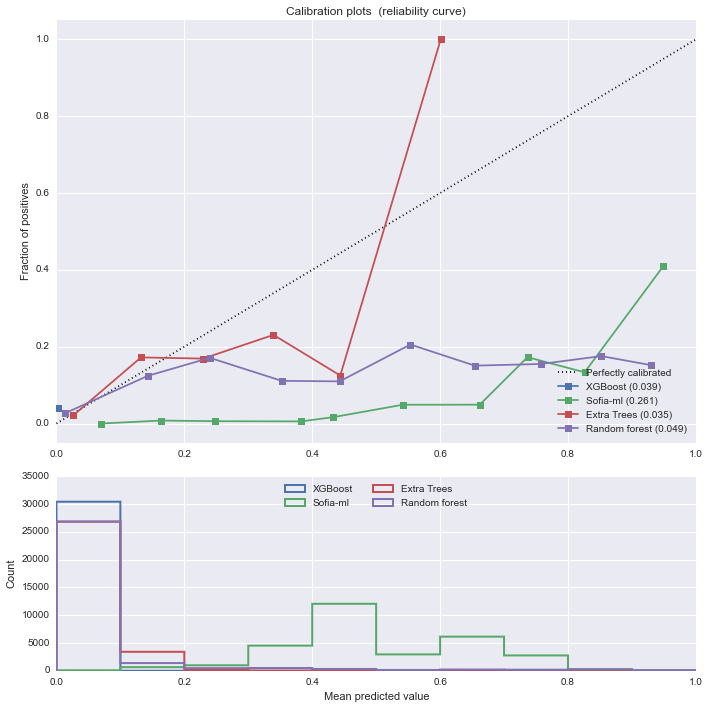

In [24]:
preds = blend_test.T
plot_calibration_curve(preds, ["XGBoost",  "Sofia-ml", "Extra Trees","Random forest"], 1)